# Group 4 Data Story

Our group was interested in exploring DESCRIBE SUMMARY OF OUR PROJECT

This notebook contains the following sections:
- UPDATE THIS WITH THE CONTENTS OF OUR NOTEBOOK!

## 0. Setup and Installation

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization


## 0.1 Data Loading and Preprocessing
### 0.1.1 Load Dataset

In [28]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

### 0.1.2 Define Helper Functions and Load Variables

In [29]:
# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

# Part 1: Interpretability & Input Features

## 1.1 Input Feature Distributions

Define latitude masks and plot histograms for tropical vs. non-tropical regions:

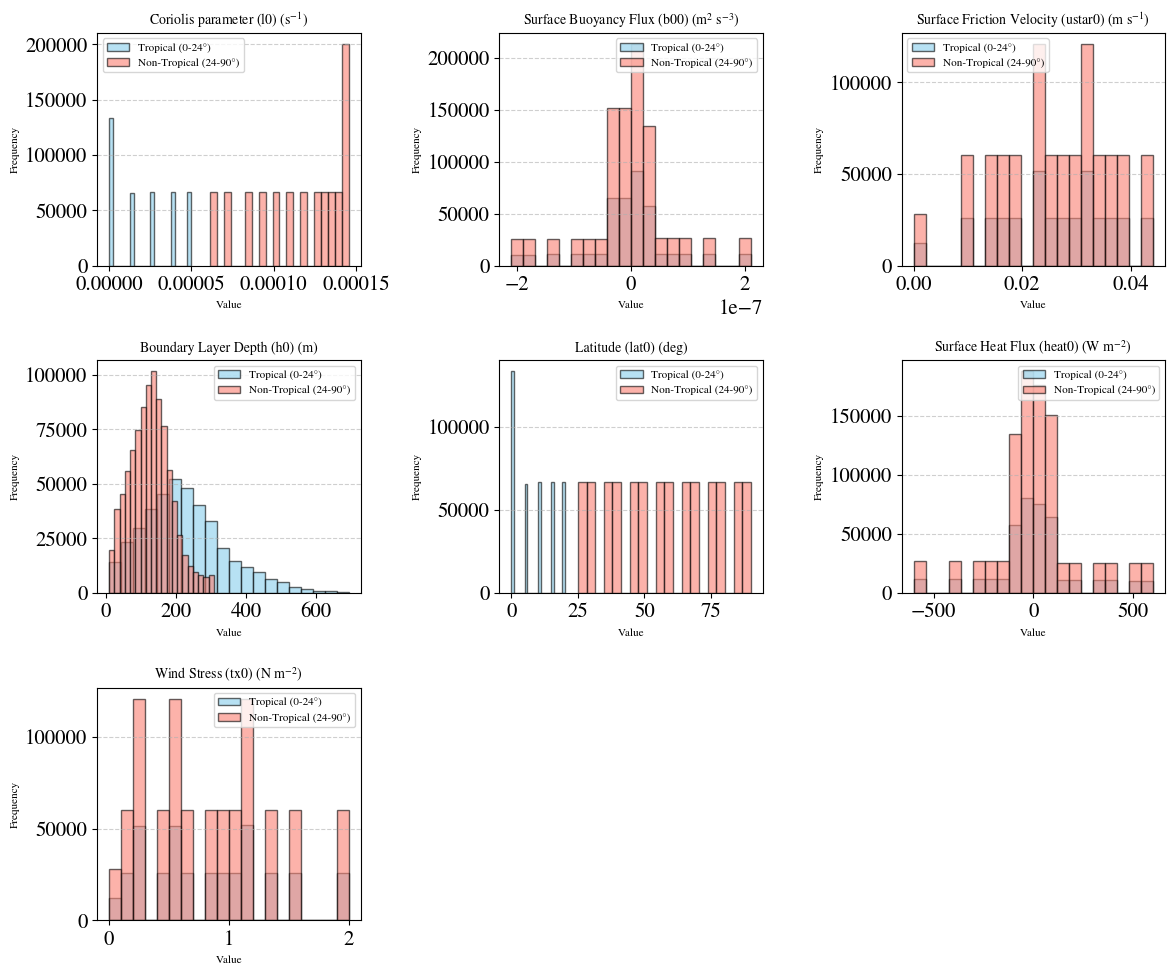

In [30]:
# Define latitude masks
tropical_mask = (lat0.values >= 0) & (lat0.values <= 24)
non_tropical_mask = (lat0.values > 24) & (lat0.values <= 90)

# Define variables for plotting
variables = {
    "Coriolis parameter (l0) (s$^{-1}$)": l0.values,
    "Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": b00.values,
    "Surface Friction Velocity (ustar0) (m s$^{-1}$)": ustar0.values,
    "Boundary Layer Depth (h0) (m)": h0.values,
    "Latitude (lat0) (deg)": lat0.values,
    "Surface Heat Flux (heat0) (W m$^{-2}$)": heat0.values,
    "Wind Stress (tx0) (N m$^{-2}$)": tx0.values,
}

plt.figure(figsize=(12, 10))
for i, (name, data) in enumerate(variables.items()):
    plt.subplot(3, 3, i + 1)
    plt.hist(data[tropical_mask], bins=20, color="skyblue", edgecolor="black", alpha=0.6, label="Tropical (0-24°)")
    plt.hist(data[non_tropical_mask], bins=20, color="salmon", edgecolor="black", alpha=0.6, label="Non-Tropical (24-90°)")
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## 1.2 Correlation Analysis by Latitude Region

Separate data into tropical and non-tropical datasets, compute correlations, and plot heatmaps:

In [31]:
# Build dictionaries for tropical and non-tropical data
data_tropical = {
    "l0": l0[tropical_mask].values,
    "b00": b00[tropical_mask].values,
    "ustar0": ustar0[tropical_mask].values,
    "h0": h0[tropical_mask].values,
    "lat0": lat0[tropical_mask].values,
    "heat0": heat0[tropical_mask].values,
    "tx0": tx0[tropical_mask].values,
}
data_non_tropical = {
    "l0": l0[non_tropical_mask].values,
    "b00": b00[non_tropical_mask].values,
    "ustar0": ustar0[non_tropical_mask].values,
    "h0": h0[non_tropical_mask].values,
    "lat0": lat0[non_tropical_mask].values,
    "heat0": heat0[non_tropical_mask].values,
    "tx0": tx0[non_tropical_mask].values,
}

# Append SF0_1 ... SF0_16 to each dictionary
for i in range(16):
    layer_index = 16 - i - 1
    data_tropical[f"SF0_{i+1}"] = SF0[tropical_mask, layer_index].values.flatten()
    data_non_tropical[f"SF0_{i+1}"] = SF0[non_tropical_mask, layer_index].values.flatten()

# Create DataFrames and compute correlation matrices
df_tropical = pd.DataFrame(data_tropical)
df_non_tropical = pd.DataFrame(data_non_tropical)
corr_tropical = df_tropical.corr()
corr_non_tropical = df_non_tropical.corr()

# Extract correlations for diffusivity (SF0 layers) vs. selected input variables
cols = ["l0", "b00", "ustar0", "h0", "lat0", "heat0", "tx0"]
sf0_corr_tropical = corr_tropical.loc["SF0_1":"SF0_16", cols]
sf0_corr_non_tropical = corr_non_tropical.loc["SF0_1":"SF0_16", cols]


Sum and plot the absolute correlations to compare overall strength:

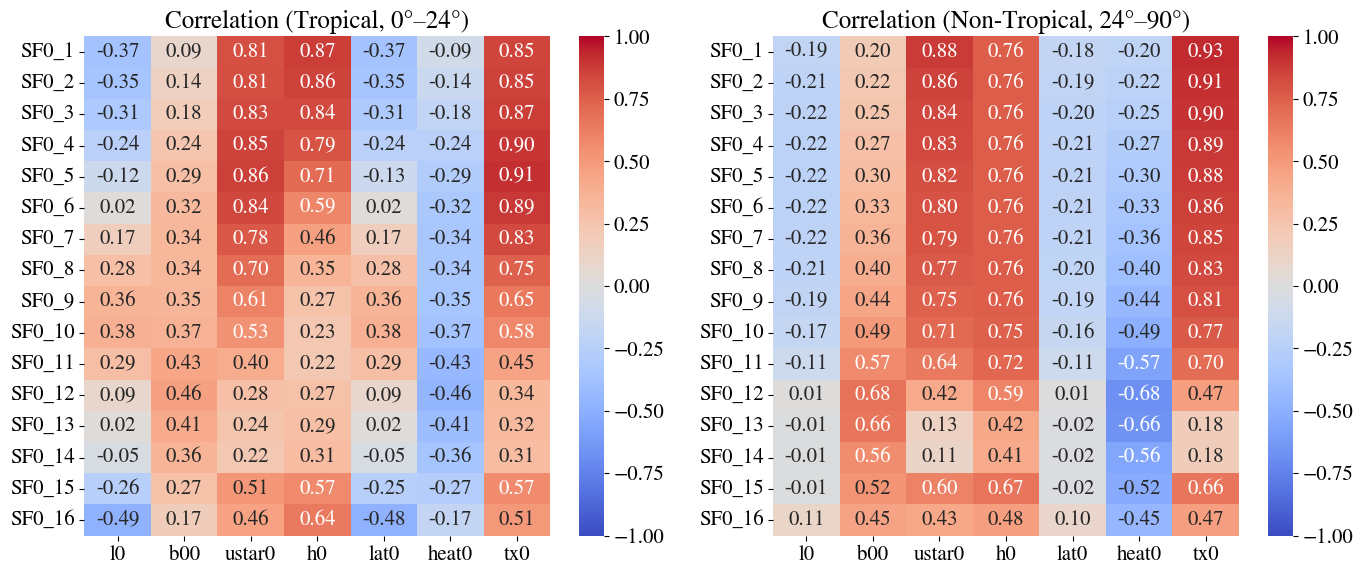

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(sf0_corr_tropical, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, ax=ax1)
ax1.set_title("Correlation (Tropical, 0°–24°)")
sns.heatmap(sf0_corr_non_tropical, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, ax=ax2)
ax2.set_title("Correlation (Non-Tropical, 24°–90°)")
plt.tight_layout()
plt.show()

1. Wind-driven mixing (ustar0 and tx0) dominates in both tropical and non-tropical regions.

2. Boundary layer depth (h0) has stronger correlations in non-tropical waters, likely due to greater variability in deep mixing.

3. Heat flux (heat0) has a much greater influence in non-tropical regions, particularly in deeper layers, likely due to seasonal heat loss driving deep convection.

4. Latitude (lat0) is less important overall, but weakly negative in non-tropical deep layers.

5. Coriolis effects (l0) show moderate negative correlations in the tropics but are weaker in non-tropical waters.


The results suggest that surface processes (wind stress, boundary layer depth) are the primary controls of diffusivity, with heat flux and Coriolis effects playing secondary roles. The biggest differences between the two regions arise in how deep mixing extends—in non-tropical waters, mixing extends deeper due to stronger seasonal variations in heat flux and wind stress.

## 1.3 Define the Neural Network

Define the model:

In [35]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)
        self.linear2 = nn.Linear(Hid, Hid)
        self.linear3 = nn.Linear(Hid, Out_nodes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        h1 = torch.relu(self.linear1(x))
        h1 = self.dropout(h1)
        h2 = torch.relu(self.linear2(h1))
        h2 = self.dropout(h2)
        y_pred = self.linear3(h2)
        return y_pred


Define the training function:

In [36]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = torch.nn.L1Loss(reduction='mean')
    loss_array = torch.zeros([epochs, 3])
    best_loss = float('inf')
    no_improvement = 0
    best_model_state = None

    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()
            y_pred = model(x)
            valid_pred = model(valid_x)
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            loss.backward()
            optimizer.step()

            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  
            pbar.set_postfix(train_loss=loss_train.item(), valid_loss=loss_valid.item(), patience_count=no_improvement)
            pbar.update(1)

            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()
                no_improvement = 0
                best_model_state = model.state_dict()
            else:
                no_improvement += 1
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}.")
                break
            del loss, y_pred

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, loss_array[:k, :]


## 1.4 Data Filtering and NN Training

### 1.4.1 Tropical

Apply filtering based on your constraints and prepare the training and validation data:

In [49]:
# Create indices based on defined filters
ind_lat = np.where(tropical_mask)[0]
ind_heat = np.where(np.abs(heat0) < 601)[0]
ind1 = np.intersect1d(ind_lat, ind_heat)
ind2 = np.where(tx0 < 1.2)[0]
ind3 = np.where(h0 > 29)[0]
ind4 = np.where(h0 < 301)[0]
ind5 = np.intersect1d(ind1, ind2)
ind6 = np.intersect1d(ind3, ind5)
ind7 = np.intersect1d(ind4, ind6)

# There are 16 SF0 levels (from bottom to top)
mm1, mm2 = 0, 16
data_load_main = np.zeros([len(h0[ind7]), 4 + (mm2 - mm1)])
data_load_main[:, 0] = l0[ind7]
data_load_main[:, 1] = b00[ind7]
data_load_main[:, 2] = ustar0[ind7]
data_load_main[:, 3] = h0[ind7]
data_load_main[:, 4:(mm2 - mm1 + 4)] = SF0[ind7, mm1:mm2]

data_forc = np.zeros([len(ind7), 3])
data_forc[:, 0] = lat0[ind7]
data_forc[:, 1] = heat0[ind7]
data_forc[:, 2] = tx0[ind7]

data_load3 = copy.deepcopy(data_load_main)

Preprocess the training data and load validation data:

In [50]:
data, x, y, stats, k_mean, k_std = ff.preprocess_train_data(data_load3)

# Load validation data from URL
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df_valid = pd.read_csv(url, delim_whitespace=True, header=None)
valid_data = df_valid.iloc[:, 3:].values

ind3 = np.where(valid_data[:, 3] > 29)[0]
ind4 = np.where(valid_data[:, 3] < 301)[0]
ind = np.intersect1d(ind3, ind4)
valid_x = valid_data[ind, 0:4]
valid_x[:, 0] = (valid_x[:, 0] - stats[0]) / stats[1]
valid_x[:, 1] = (valid_x[:, 1] - stats[2]) / stats[3]
valid_x[:, 2] = (valid_x[:, 2] - stats[4]) / stats[5]
valid_x[:, 3] = (valid_x[:, 3] - stats[6]) / stats[7]

valid_y = valid_data[ind, 5:]
for i in range(len(valid_y)):
    valid_y[i, :] = np.log(valid_y[i, :] / np.max(valid_y[i, :]))
for i in range(16):
    valid_y[:, i] = (valid_y[:, i] - k_mean[i]) / k_std[i]

# Convert to torch tensors
x = torch.FloatTensor(x).to(device)
y = torch.FloatTensor(y).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)
valid_y = torch.FloatTensor(valid_y).to(device)


## 1.4.1.1 Train the Neural Network

Train the model:

In [51]:
epochs, lr = 3000, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16
torch.manual_seed(10)
k_mean_c = torch.tensor(k_mean).float().to(device)
k_std_c = torch.tensor(k_std).float().to(device)
kmask = np.ones(16)  # Or use your custom weights
model = learnKappa_layers(in_nod, hid_nod, o_nod).to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

Training Progress:   2%|▏         | 65/3000 [00:00<00:34, 84.77epoch/s, patience_count=19, train_loss=0.0797, valid_loss=0.182]


Early stopping at epoch 65.


Plot training and validation loss:

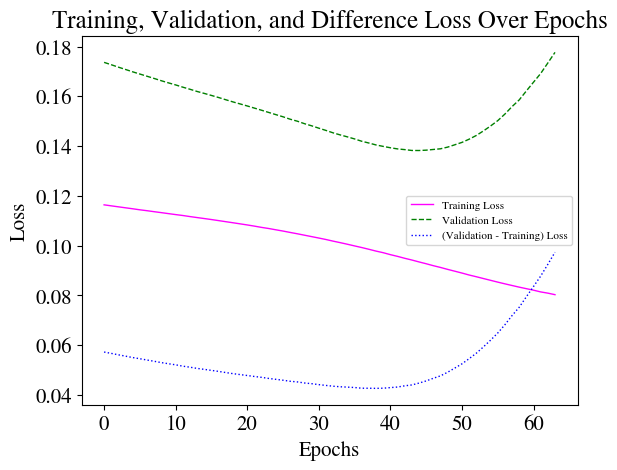

In [52]:
validation_minus_training = loss_array[:, 2] - loss_array[:, 1]
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss", color="magenta", linestyle="-")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss", color="green", linestyle="--")
plt.plot(loss_array[:, 0], validation_minus_training, label="(Validation - Training) Loss", color="blue", linestyle=":")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Difference Loss Over Epochs")
plt.legend()
plt.show()


The plot shows increasing validation loss after ~50 epochs, meaning the model starts to lose generalization ability. Early stopping should be considered.

Evaluate model performance:

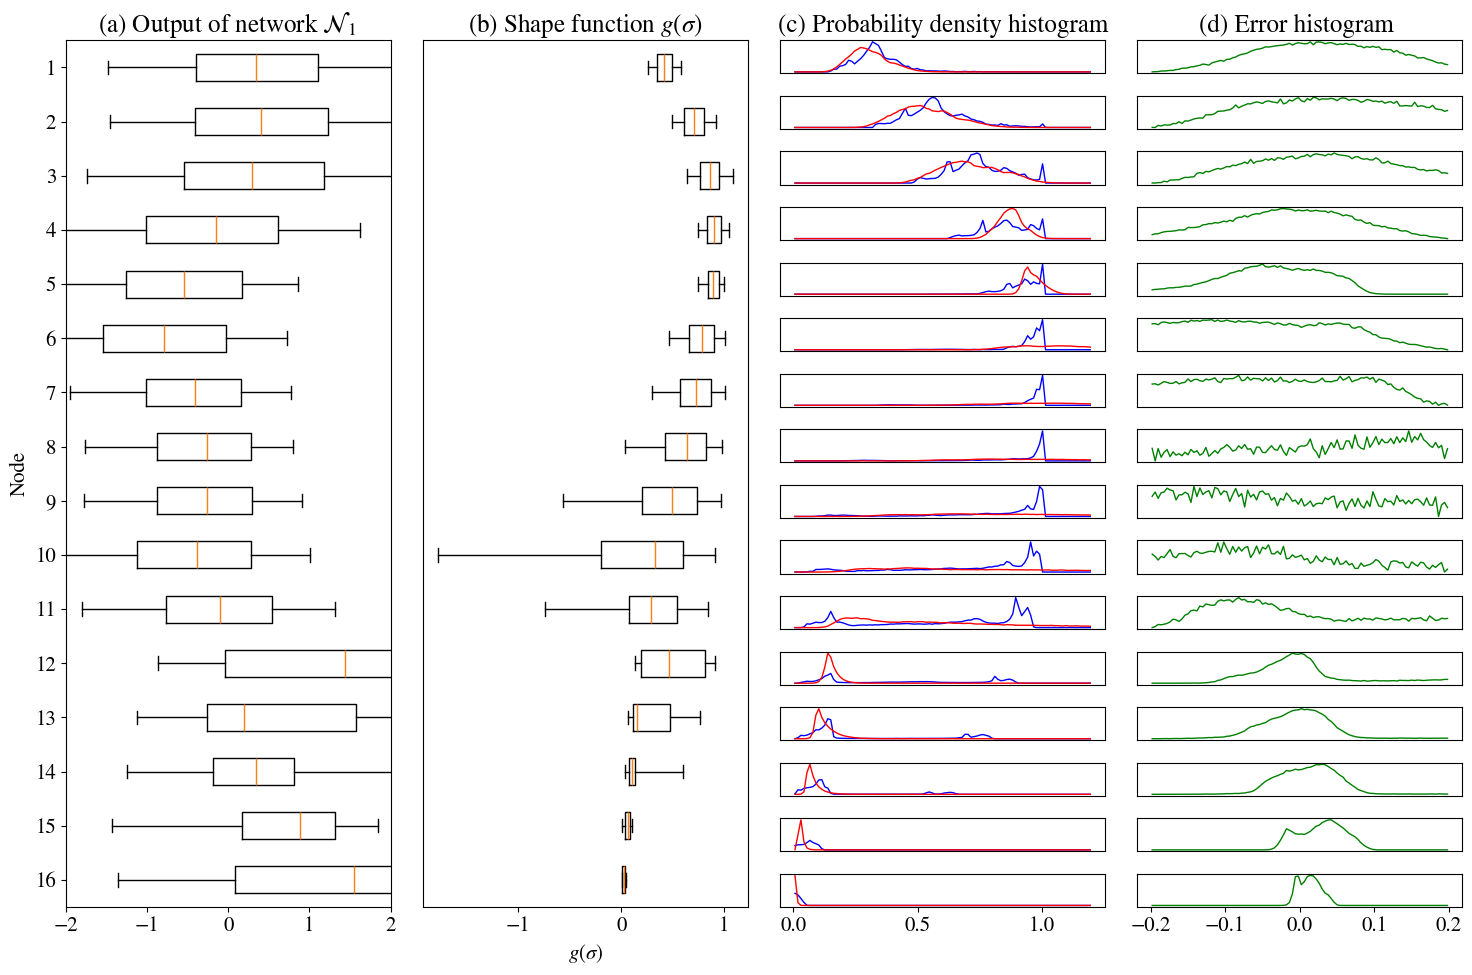

In [53]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

### 1.4.2 Non-Tropical

In [43]:
# Create indices based on defined filters
ind_lat = np.where(non_tropical_mask)[0]
ind_heat = np.where(np.abs(heat0) < 601)[0]
ind1 = np.intersect1d(ind_lat, ind_heat)
ind2 = np.where(tx0 < 1.2)[0]
ind3 = np.where(h0 > 29)[0]
ind4 = np.where(h0 < 301)[0]
ind5 = np.intersect1d(ind1, ind2)
ind6 = np.intersect1d(ind3, ind5)
ind7 = np.intersect1d(ind4, ind6)

# There are 16 SF0 levels (from bottom to top)
mm1, mm2 = 0, 16
data_load_main = np.zeros([len(h0[ind7]), 4 + (mm2 - mm1)])
data_load_main[:, 0] = l0[ind7]
data_load_main[:, 1] = b00[ind7]
data_load_main[:, 2] = ustar0[ind7]
data_load_main[:, 3] = h0[ind7]
data_load_main[:, 4:(mm2 - mm1 + 4)] = SF0[ind7, mm1:mm2]

data_forc = np.zeros([len(ind7), 3])
data_forc[:, 0] = lat0[ind7]
data_forc[:, 1] = heat0[ind7]
data_forc[:, 2] = tx0[ind7]

data_load3 = copy.deepcopy(data_load_main)

In [44]:
data, x, y, stats, k_mean, k_std = ff.preprocess_train_data(data_load3)

# Load validation data from URL
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df_valid = pd.read_csv(url, delim_whitespace=True, header=None)
valid_data = df_valid.iloc[:, 3:].values

ind3 = np.where(valid_data[:, 3] > 29)[0]
ind4 = np.where(valid_data[:, 3] < 301)[0]
ind = np.intersect1d(ind3, ind4)
valid_x = valid_data[ind, 0:4]
valid_x[:, 0] = (valid_x[:, 0] - stats[0]) / stats[1]
valid_x[:, 1] = (valid_x[:, 1] - stats[2]) / stats[3]
valid_x[:, 2] = (valid_x[:, 2] - stats[4]) / stats[5]
valid_x[:, 3] = (valid_x[:, 3] - stats[6]) / stats[7]

valid_y = valid_data[ind, 5:]
for i in range(len(valid_y)):
    valid_y[i, :] = np.log(valid_y[i, :] / np.max(valid_y[i, :]))
for i in range(16):
    valid_y[:, i] = (valid_y[:, i] - k_mean[i]) / k_std[i]

# Convert to torch tensors
x = torch.FloatTensor(x).to(device)
y = torch.FloatTensor(y).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)
valid_y = torch.FloatTensor(valid_y).to(device)


## 1.4.2.1 Train the Neural Network

In [45]:
epochs, lr = 3000, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16
torch.manual_seed(10)
k_mean_c = torch.tensor(k_mean).float().to(device)
k_std_c = torch.tensor(k_std).float().to(device)
kmask = np.ones(16)  # Or use your custom weights
model = learnKappa_layers(in_nod, hid_nod, o_nod).to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

Training Progress:  44%|████▍     | 1315/3000 [00:32<00:41, 40.18epoch/s, patience_count=19, train_loss=0.0254, valid_loss=0.0556]



Early stopping at epoch 1315.


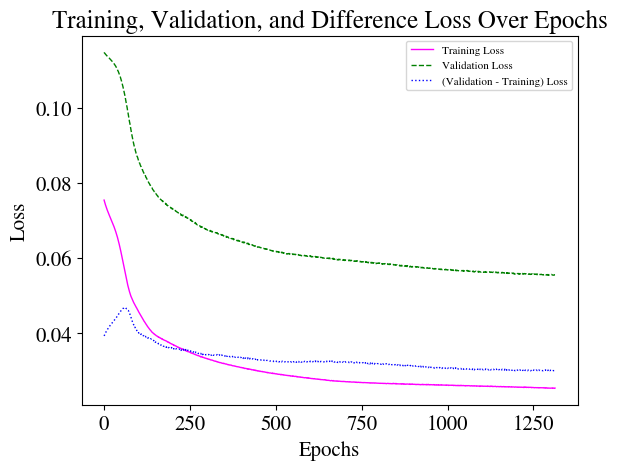

In [46]:
validation_minus_training = loss_array[:, 2] - loss_array[:, 1]
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss", color="magenta", linestyle="-")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss", color="green", linestyle="--")
plt.plot(loss_array[:, 0], validation_minus_training, label="(Validation - Training) Loss", color="blue", linestyle=":")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Difference Loss Over Epochs")
plt.legend()
plt.show()


Unlike the tropical case, where overfitting occurred after ~50 epochs, the training loss here continues to decrease steadily, suggesting a well-behaved training process.

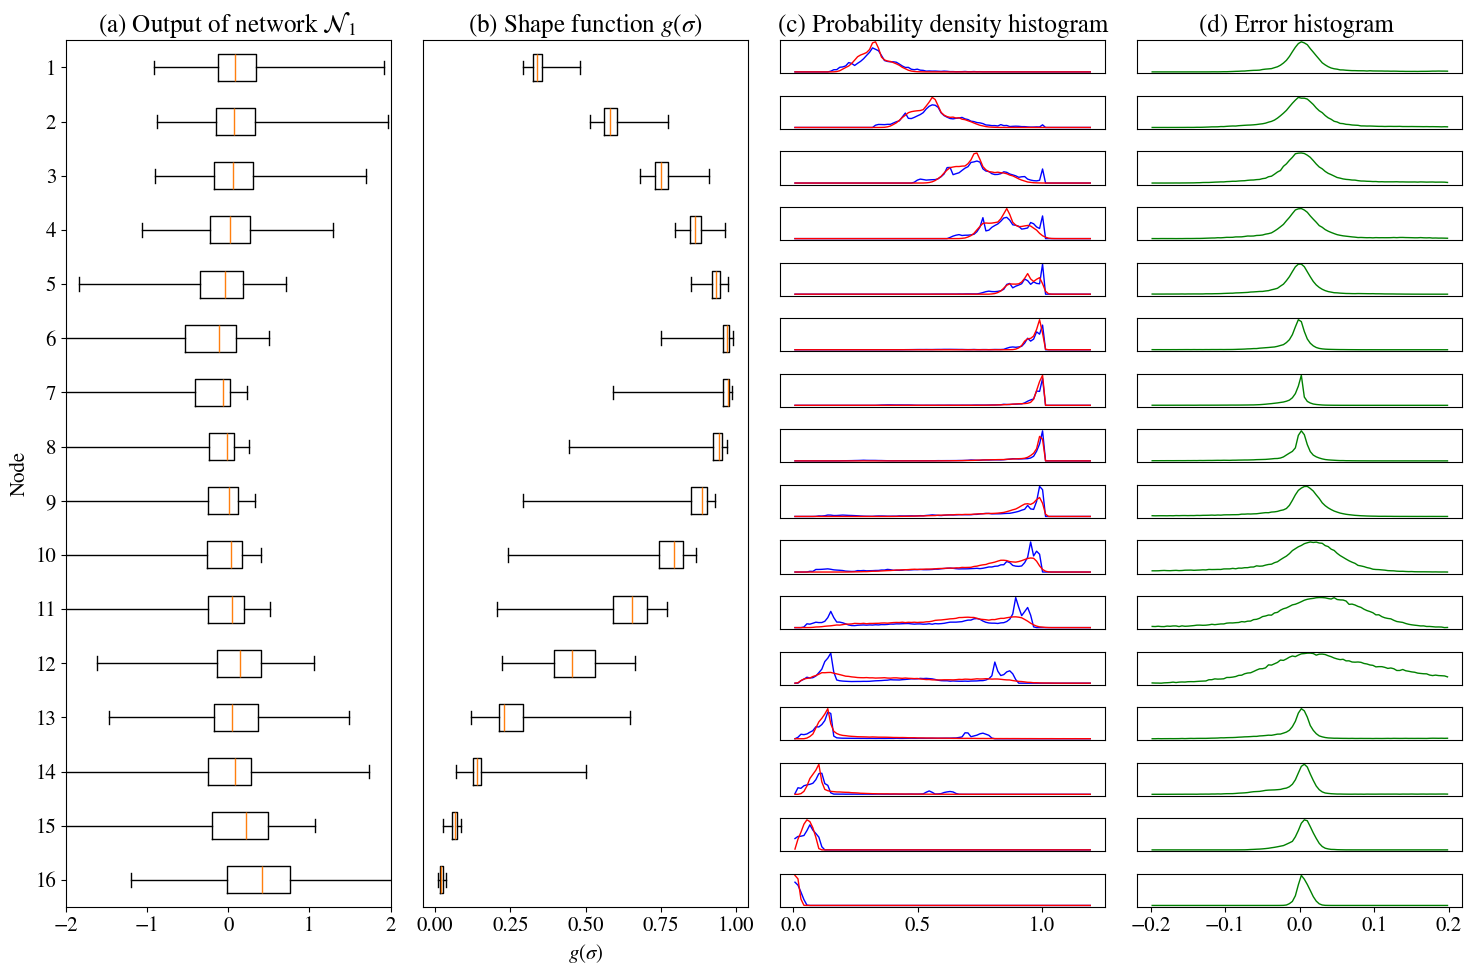

In [47]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)


The predicted shape of Shape function 𝑔(𝜎) appear to align more closely with the actual shape compared to the tropical region.

Why Does the Model Perform Better in Non-Tropical Regions?

1. More Structured Mixing Processes

- In higher latitudes, seasonal variations lead to stronger mixing events (e.g., winter convection), creating more distinct patterns in the shape function.

- The model can learn these structured patterns more effectively.

2. Tropical Mixing is More Complex

- Tropical diffusivity is influenced by surface-driven turbulence, wind stress, and weaker stratification effects, which vary significantly.

- These complex interactions make it harder for the model to generalize across different profiles.

## Mixed Layer Depth

Sane et al. (2023) found that the bias between the mixed layer depths from their neural network parametrization and the physics-based parametrization was higher in winter than spring, which corresponds to deeper mixed layers. This finding, that bias is higher with deep mixed layers, indicates there are more complicated processes at work during winter when convection can occur due to weaker stratification.

Below we calculate the correlation between our input variables (Coriolis parameter, surface bouyancy flux, surface friction velocity, and boundary layer depth) and the diffusivity shape function they correspond to based on different boundary layer depths.

In [22]:
#this function takes an upper and lower depth boundary and filters the data to only those depths
#then it computes the correlation matrix between the 4 input variables (lat, bouyancy, velocity, and depth) and each point of the shape function
def correlation_by_depth(depth_min, depth_max):
    d_depth = d.where((d.h.compute() < depth_max) & (d.h.compute() > depth_min), drop=True)
    l0_depth    =corio(d_depth['l'][:])
    b00_depth   =d_depth['b0'][:]
    ustar0_depth=d_depth['ustar'][:]
    h0_depth    =d_depth['h'][:]
    lat0_depth  =d_depth['lat'][:]
    heat0_depth =d_depth['heat'][:]
    tx0_depth   =d_depth['tx'][:] 
    tx0_depth   =np.round(tx0_depth,2)
    SF0_depth   =d_depth['SF'][:] 
    
    data_depth = {
        "l0": l0_depth.values.flatten(),
        "b00": b00_depth.values.flatten(),
        "ustar0": ustar0_depth.values.flatten(),
        "h0": h0_depth.values.flatten(),
    }
    
    for i in range(16):
        data_depth[f"SF0_{i+1}"] = SF0_depth[:, 16-i-1].values.flatten()
    
    df_depth = pd.DataFrame(data_depth)
    correlation_matrix_depth = df_depth.corr()
    sf0_correlation_depth = correlation_matrix_depth.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0"]]

    return sf0_correlation_depth

In [23]:
#select depth ranges)
bins = [0,25,50,700]

In [24]:
#compute correlation matrix for a certain depth range
correlation_0_25 = correlation_by_depth(bins[0],bins[1])
correlation_0_50 = correlation_by_depth(bins[0],bins[2])
correlation_50_700 = correlation_by_depth(bins[2],bins[3])
correlation_0_700 = correlation_by_depth(bins[0],bins[3])

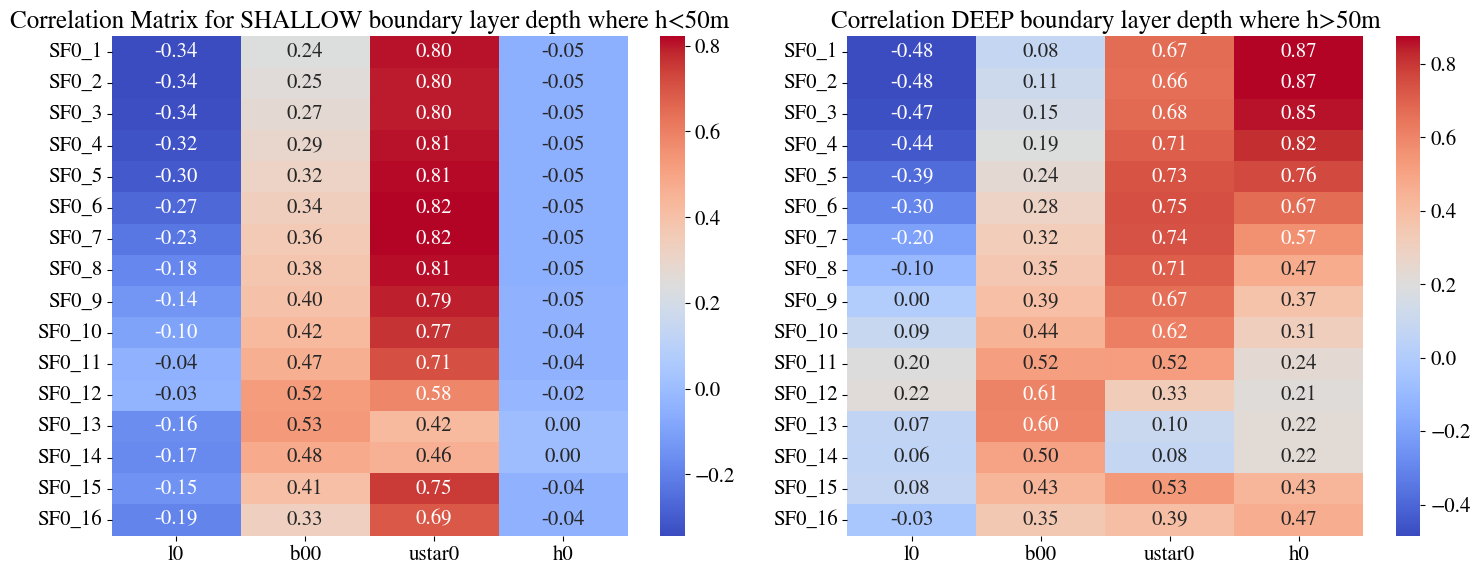

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(correlation_0_50, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[0])
axs[0].set_title("Correlation Matrix for SHALLOW boundary layer depth where h<{}m".format(bins[2]))

sns.heatmap(correlation_50_700, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[1])
axs[1].set_title("Correlation DEEP boundary layer depth where h>{}m".format(bins[2]))

plt.tight_layout()
plt.show()

The plots above show the correlation matrices for the dataset filtered in 2 ways: only the data with boundary layers less than 50m and only the data with boundary layers greater than 50m. Some of the correlations look fairly similar between the two. Bouyancy flux for example has visually very similar correlations. For shallow boundary layers, the boundary layer input has little correlation which makes sense (because we've chosen similar regimes), however for deep boundary layers there is higher correlation, likely because there is a larger range of h values. Latitude and velocity both have similar patterns in correlation, just shifted slightly (shallow boundary layers have higher correlation for velocity and lower for latitude).

These plots can be complicated to interpret because there are many values to look at. In order to simplify, we added the (absolute value of) correlation for each depth point across all four inputs to compare the overall strength of correlation for each point across different boundary layer depth regimes.

In [26]:
correlation_0_25_sum = correlation_0_25.abs().sum(axis=1)
correlation_0_50_sum = correlation_0_50.abs().sum(axis=1)
correlation_50_700_sum = correlation_50_700.abs().sum(axis=1)
correlation_0_700_sum = correlation_0_700.abs().sum(axis=1)
y = np.arange(1,17)

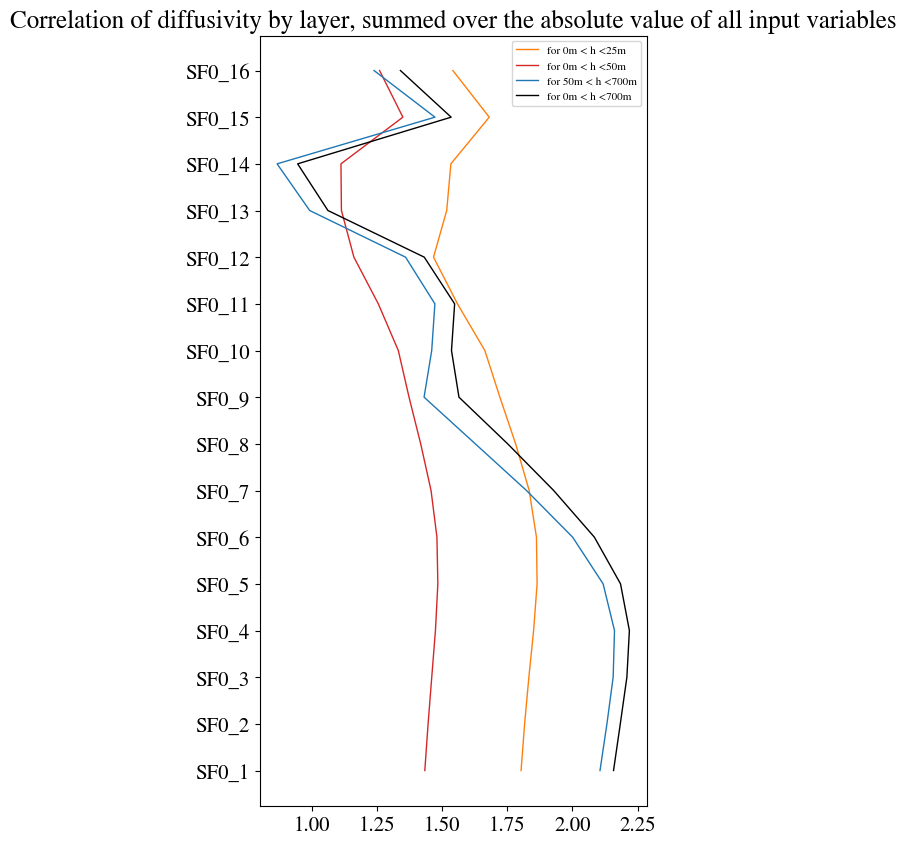

In [27]:
plt.figure(figsize=(5,10))
plt.plot(correlation_0_25_sum, y, label=f"for {bins[0]}m < h <{bins[1]}m", color='tab:orange')
plt.plot(correlation_0_50_sum, y, label=f"for {bins[0]}m < h <{bins[2]}m", color='tab:red')
plt.plot(correlation_50_700_sum, y, label=f"for {bins[2]}m < h <{bins[3]}m", color='tab:blue')
plt.plot(correlation_0_700_sum, y, label=f"for {bins[0]}m < h <{bins[3]}m", color='k')
#plt.gca().invert_yaxis()
plt.legend()
plt.yticks(ticks=np.arange(1,17,1),labels=['SF0_1','SF0_2','SF0_3','SF0_4','SF0_5','SF0_6','SF0_7','SF0_8','SF0_9','SF0_10','SF0_11','SF0_12','SF0_13','SF0_14','SF0_15','SF0_16']);
plt.title('Correlation of diffusivity by layer, summed over the absolute value of all input variables');

This plot shows the absolute value of correlation summed across all 4 inputs for each point of the shape function for four different boundary layer depth regimes:
- 0 < h < 25: very shallow boundary layers (this would indicate high stratification, likely in summer)
- 0 < h < 50: shallow boundary layers
- 50 < h < 700: deep boundary layers (this would indicate weak stratification, likely in winter)
- 0 < h < 700: entire dataset, no sorting by boundary layer depth

This plot indicates that the highest correlation at the surface (point 16) is for very shallow boundary layers, those less than 25m. This relates to the paper's finding that shallow boundary layers had lower bias. Interesting though, there is not a significant differnce between all shallow boundary layers (0<h<25) compared to deep boundary layers (50<h<700) in the upper points of the profile. This could suggest that high correlation is specific to a very small group of the shallowest mixed layers. Contrastingly, at the base of the profile (deeper in the ocean, at point 1) deep mixed layers have the highest correlation. 

# Part 2: Model Improvement

[CL] work on step-by-step model architecture

[BH] work on XGBoost model? (if it seems like it's training)